In [86]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Input, Dense, Lambda
from tensorflow.keras.layers import Add, Concatenate, Reshape, Flatten, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomUniform

from time import time

# Building data

## Equations of motion

In [2]:
k = -1.0
gamma = 0.5
m = 1

n_dims = 1

f = lambda x: -(k*x + gamma*x**3)

SHO_equations = lambda t, X: [X[1]/m, f(X[0])]

## Dataset construction

In [3]:
n_dims = 1
time_step = 0.5

N_train = 10000

X0_train = np.empty([N_train, 2, n_dims], dtype=np.float64)
X1_train = np.empty([N_train, 2, n_dims], dtype=np.float64)

for i in range(N_train):
  sol = solve_ivp(SHO_equations, [0,time_step],
                  np.random.normal(0, 2, 2)).y.transpose()
  X0_train[i] = np.expand_dims(sol[0], axis=-1)
  X1_train[i] = np.expand_dims(sol[-1], axis=-1)

# Model Setup

## Potential Network

In [158]:
class swish_layer(Layer):

    def __init__(self, units, w_scale = 1.0, reg_scale=0.0, **kwargs):
        self.units = units
        self.swish = lambda x: K.sigmoid(x) * x
        
        self.k_init = RandomUniform(-w_scale, w_scale)
        self.b_init = RandomUniform(-w_scale, w_scale)
        
        self.k_regularizer = keras.regularizers.l2(reg_scale)
        self.b_regularizer = keras.regularizers.l2(reg_scale)
        
        super(swish_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      regularizer=self.k_regularizer,
                                      initializer=self.k_init)
        
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.units,),
                                    regularizer=self.b_regularizer,
                                    initializer=self.b_init)
        
        super(swish_layer, self).build(input_shape)

    def call(self, x):
        output = self.swish(K.dot(x, self.kernel))
        output = K.bias_add(output, self.bias)
        return self.swish(output)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
def swish_mlp(input_dim, output_dim, layers,
              reg_scale = 0.01, weight_scale = 1.0):
    
    X = [Input(shape=(input_dim,))]
    
    for i, layer in enumerate(layers):
        X += [swish_layer(layer)(X[i])]
    
    X += [swish_layer(output_dim)(X[i])]
    
    return Model(inputs=X[0], outputs=X[-1])

## Global minimizer (doesn't work)

In [ ]:
class g_layer(Layer):

    def __init__(self, output_dim, l_reg, **kwargs):
        self.output_dim = output_dim 
        self.a_regularizer = keras.regularizers.l2(l_reg)
        self.b_init = RandomUniform(-0.1, 0.1)
        super(g_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[1], self.output_dim),
                                 initializer=keras.initializers.glorot_uniform())
        
        self.b = self.add_weight(name='b', 
                                 shape=(self.output_dim,),
                                 initializer=self.b_init)
        
        self.a = self.add_weight(name='a', 
                                 shape=(self.output_dim,),
                                 initializer=self.b_init,
                                 regularizer=self.a_regularizer)
        
        super(g_layer, self).build(input_shape)

    def call(self, x):
        output = K.dot(x, self.W)
        output = K.exp(K.bias_add(output, self.b))
        return Multiply()([self.a, output])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

## Solver Network

In [136]:
def hamiltonian_time_evolution(n_dims, potential):
    X = Input(shape=(2,n_dims,))

    Q = Lambda(lambda x: x[:,0])(X)
    P = Lambda(lambda x: x[:,1])(X)

    T = Lambda(lambda p: tf.reduce_sum((1/(2*m))*p**2))(P)
    #V = Lambda(lambda q: tf.reduce_sum((k/2)*q**2 + (gamma/4)*q**4))(Q)
    V = potential(Q)

    gradients = Lambda(lambda x: tf.gradients(x[0],x[1])[0])

    dPdt = Lambda(lambda x: tf.negative(x))(gradients((V,Q)))
    dQdt = gradients((T,P))
    
    dPQdt = Reshape((2,n_dims))(Concatenate(axis=-1)([dQdt,dPdt]))

    return Model(inputs=X, outputs=dPQdt)

def rk4_step(f, n_dims, time_step):
    X0 = Input(shape=(2,n_dims,))

    k1 = f(X0)
    k2 = f(Add()([X0, Lambda(lambda k: (time_step/2)*k)(k1)]))
    k3 = f(Add()([X0, Lambda(lambda k: (time_step/2)*k)(k2)]))
    k4 = f(Add()([X0, Lambda(lambda k: time_step*k)(k3)]))
    
    k5 = Add()([k1,Lambda(lambda k: 2*k)(k2),
                Lambda(lambda k: 2*k)(k3),k4])
    
    X1 = Lambda(lambda k: (time_step/6)*k)(k5)
    
    return Model(inputs=X0, outputs=X1)

def prediction_model(n_dims, f, time_step):
    X0 = keras.layers.Input(shape=(2,n_dims,))
    
    dXdt = hamiltonian_time_evolution(n_dims, f)
    dX = rk4_step(dXdt, n_dims, time_step)

    return Model(inputs=X0, outputs=Add()([X0, dX(X0)]))

## Complete Model

In [164]:
prediction_steps = 1

Fq = swish_mlp(n_dims, 1, [10,20,10],
               reg_scale=0.0, weight_scale = 1.0)

#X0 = keras.layers.Input(shape=(2, n_dims))
#p = prediction_model(n_dims, Fq, time_step)
#g = g_layer(n_dims, 1.0)(Flatten()(X0))
#model = Model(inputs=X0, outputs=Add()([p(X0), g]))

model = prediction_model(n_dims, Fq, time_step)

model.compile(optimizer=keras.optimizers.Nadam(lr=0.001),
                loss='mse', metrics=['mse'])

8.782206773757935


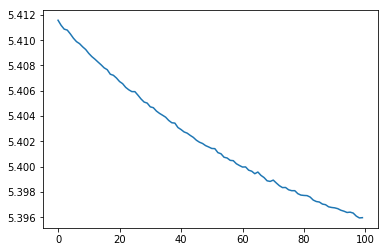

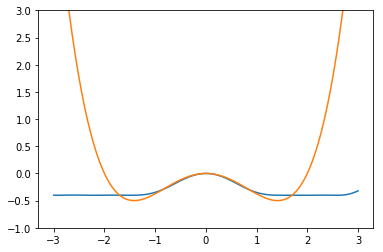

In [166]:
start = time()
result = model.fit(x=X0_train,y=X1_train,
                     batch_size=1000, epochs=100, shuffle=True, verbose=0)
print(time()-start)

plt.plot(result.history['loss'])

plt.show()

q = np.linspace(-3,3,100)
q0 = Fq.predict([0])[0,0]
plt.plot(q, Fq.predict(q)[:,0]-q0)
plt.plot(q, (k*q**2)/2+(gamma*q**4)/4)
plt.ylim([-1,3])
plt.show()

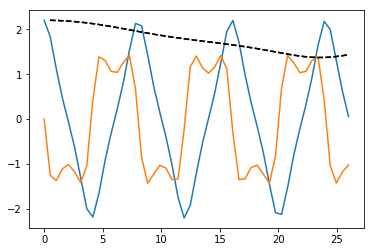

In [167]:
n_points = 50
duration = time_step*n_points+1

xp = [2.2,0]
t = np.linspace(0, duration,n_points+1)
X = solve_ivp(SHO_equations, [0,duration], xp, t_eval=t).y.transpose()

plt.plot(t, X)

prediction = np.empty([n_points,2])

xp = np.reshape(np.array(xp), (1,2,1))
for i in range(n_points):
    xp = model.predict(xp)
    prediction[i] = xp[0,0]
  
plt.plot(np.linspace(time_step, duration, n_points),
         prediction, '--k')